# Gerrymandering Notebook

Based on GerryChain package.

Sources:

- https://github.com/mggg-states/PA-shapefiles

- https://ballotpedia.org/Redistricting_in_Pennsylvania#cite_note-indy-2

- https://github.com/uwescience/dssg2021-redistricting/blob/main/Georgia/GA_gerrychain.py

In [2]:
pip install gerrychain  ## *****

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import sys
import re
import tqdm

import csv
import json
import random
import math
import numpy

from functools import partial, reduce
import pandas
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt
import seaborn

import gerrychain

from gerrychain import (
     Election,
     Graph,
     MarkovChain,
     Partition,
     accept,
     constraints,
     updaters
)

import networkx as nx

from gerrychain.metrics import efficiency_gap, mean_median, polsby_popper, wasted_votes, partisan_bias
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part, bipartition_tree_random
from gerrychain.accept import always_accept
from gerrychain.constraints import (Validator, single_flip_contiguous,
within_percent_of_ideal_population, UpperBound)

In [2]:
## utility_functions, used to create the graph of nodes

def plot_district_map(df, assignment_dict, title=None, output_path=None, map_colors=None):
    """
    visualize districts corresponding to a given assignment_dict
    mapping index in geopandas dataframe to desired districts per node
    If output_path not provided, will just display image. Otherwise save to location
    
    To customize map colors, input chosen string name of matplotlib's built-in colormaps in map_colors
    If map_colors not provided, cmap will be set to default
    https://matplotlib.org/stable/gallery/color/colormap_reference.html
    https://matplotlib.org/stable/tutorials/colors/colormaps.html
    """
    df['district_assignment'] = df.index.map(assignment_dict)
    df.plot(column='district_assignment', edgecolor=(1, 1, 1, 0.05), 
            cmap=map_colors, figsize=(12, 8))
    plt.axis("off")
    if title:
        plt.title(title)
    if output_path:
        plt.savefig(output_path)
    else:
        plt.show()


def add_other_population_attribute(graph, total_column_list=["VAP"],
                                   target_population_column_list=["BVAP"],
                                   other_population_name="nBVAP"):
    """
     calculates other population value by finding difference between total
     population and target population. For example, return graph with
     non-BVAP attribute using VAP & BVAP values

    :param graph: networkx graph object
    :param total_column_list: list of all attributes to consider in the 'total population' (e.g. VAP)
    :param target_population_column_list: list of all attributes to consider in the 'target population' (e.g. BVAP)
    :param other_population_name: string - identifer for other population
    :return:
    """

    for node in graph.nodes():
        total_sum = reduce(lambda a, b: a+b, [graph.nodes[node][att]
                                              for att in total_column_list])
        target_sum = reduce(lambda a, b: a+b, [graph.nodes[node][att]
                                               for att in target_population_column_list])
        graph.nodes[node][other_population_name] = total_sum - target_sum

    return graph

def convert_attributes_to_int(graph, attribute_list):
    """
    helper function for casting attributes from string to int
    """
    for n in graph.nodes():
        for attribute in attribute_list:
            graph.nodes[n][attribute] = int(float(graph.nodes[n][attribute]))

    return graph

def convert_attributes_to_float(graph, attribute_list):
    """
     helper function for casting attributes from string to float
     """
    for n in graph.nodes():
        for attribute in attribute_list:
            graph.nodes[n][attribute] = float(graph.nodes[n][attribute])
    return graph


def export_all_metrics_per_chain(chain, output_path,
                                 buffer_length=2000,
                                 include_election=True,
                                 exclude_metrics=['cut_edges', 'boundary_nodes',
                                                  'cut_edges_by_part',
                                                  'area', 'perimeter',
                                                  'interior_boundaries', 'exterior_boundaries'
                                                  ]
                                 ):

    """
    save all metrics for every k steps (k=buffer length) of chain in separate csv file
    Additionally, saves partition assignment at kth step of chain as json

    :param chain: GerryChain chain generator object
    :param output_path: folder to save results in (separate dir per chain)
    :param buffer_length: frequency at which data is written to file
    :param include_election: boolean - specifies whether election related metrics should be saved
    :param exclude_metrics: list - metrics to exclude from output files. All metrics not at district level
                            should be excluded.
    :return:
    """

    os.makedirs(output_path, exist_ok=True)

    all_res = []
    election_res = []
    for i, part in enumerate(chain):
        results = export_all_metrics_per_partition(part, include_election, exclude_metrics)
        all_res.append(results[0].values)

        if include_election:
            election_res.append(results[1].values)

        # save results every i = buffer_length steps
        if (i+1) % buffer_length == 0:
            print(i+1)

            # save non-election related metric results
            for n, metric_name in enumerate(results[0].columns):
                with open(os.path.join(output_path, f"{metric_name}_{str(i+1)}.csv"), 'w') as f:
                    writer = csv.writer(f, lineterminator="\n")
                    writer.writerows(np.array(all_res)[:, :, n])

            all_res = []

            if include_election:
                # save election related metric results
                for n, metric_name in enumerate(results[1].columns):
                    if metric_name == 'percent': #different format - save per election in sep file
                        for row, election_name in enumerate(results[1].index):
                            with open(os.path.join(output_path, f"{election_name}_{metric_name}_{str(i+1)}.csv"), 'w') as f:
                                writer = csv.writer(f, lineterminator='\n')
                                writer.writerows(np.array(election_res)[:, row, n])
                    else: # all other election metrics saved in single file
                        with open(os.path.join(output_path, f"{metric_name}_{str(i+1)}.csv"), 'w') as f:
                            writer = csv.writer(f, lineterminator='\n')
                            writer.writerows(np.array(election_res)[:, :, n])

                election_res = []

            # save assignment for every i steps
            with open(os.path.join(output_path, f'assignment_{str(i+1)}.json'), "w") as f:
                json.dump(dict(part.assignment), f)




def export_all_metrics_per_partition(partition, include_election=True,
                                     exclude_metrics=['cut_edges']):
    """
    returns tuple of dataframes with common metrics calculated at district level
    (split by nonelection & election related)

    :param partition:
    :param include_election: boolean
    :param exclude_metrics: metrics tracked in updater to exclude from export
    :return: returns tuple of dataframe - (nonelection related metrics, election related metrics)
    """
    metric_results = {}
    for name, func in partition.updaters.items():
        if type(func) == Election or name in exclude_metrics:
            continue
        metric_results[name] = partition[name]

    metric_results = pd.DataFrame.from_dict(metric_results)

    if include_election:
        election_results=export_election_metrics_per_partition(partition)
        return (metric_results, election_results)

    return (metric_results,)


def export_election_metrics_per_partition(partition):
    """
    returns dataframe with following metrics for all elections tracked in updater
    using the given partition

    * percent won by first party
    * mean_median score
    * efficiency gap
    * seats won

    :param partition:
    :return: pd dataframe election_results
    """
    elections_info = {}

    # identify elections related updaters being tracked per partition
    for name, func in partition.updaters.items():
        if type(func) == Election:
            elections_info[name] = func.parties

    election_results = {name: {} for name in elections_info.keys()}

    # store stats for each election
    for election_name, parties in elections_info.items():
        election_results[election_name]['percent'] = partition[
            election_name].percents(parties[0])
        election_results[election_name]['efficiency_gap'] = efficiency_gap(
            partition[election_name])
        election_results[election_name]['mean_median'] = mean_median(
            partition[election_name])
        election_results[election_name]['wins'] = partition[
            election_name].wins(parties[0])

    return pd.DataFrame.from_dict(election_results, orient='index')

In [9]:
# Create graph and df objects from data *****
graph = Graph.from_file("/work/data/PA/PA.shp") # Must be adapted for each person's directory
df = gpd.read_file("/work/data/PA/PA.shp")      # Must be adapted for each person's directory


/root/venv/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/root/venv/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)


In [10]:
centroids = df.centroid
c_x = centroids.x
c_y = centroids.y

for node in graph.nodes():
    graph.nodes[node]["C_X"] = c_x[node]
    graph.nodes[node]["C_Y"] = c_y[node]
    
xgraph = convert_attributes_to_int(graph, ['CD_2011'])

In [11]:
#--Set some parameters based on PA
state_abbr="PA"
housen="CON"
num_districts=18
pop_col="TOTPOP"
#num_elections=4

#Make an output directory to put files in
newdir = "./Outputs/"+state_abbr+housen+"_Precincts/"
os.makedirs(newdir, exist_ok=True)
with open(newdir + "init.txt", "w") as f:
    f.write("Create Folder")

#--Generic updaters
# Population updater, for computing how close to equality the district
# populations are. "TOTPOP" is the population column from our shapefile.
updater = {
    "population": gerrychain.updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges
             }

In [12]:
election_names=[
    "PRES16",
    "PRES12",
    "BVAP",
    "HVAP",
    "WVAP",
    "BHVAP"]

num_elections = len(election_names)

election_columns=[
    ["T16PRESR", "T16PRESD"],
    ["PRES12R", "PRES12D"],
    ["BVAP", "nBVAP"],
    ["HVAP", "nHVAP"],
    ["WVAP", "nWVAP"],
    ["BHVAP", "nBHVAP"]
    ]

In [13]:
#--Setup election updaters
# Election updaters, for computing election results using the vote totals
# from our shapefile.
elections = [
    Election(
        election_names[i], #Name of election
        {"First": election_columns[i][0], "Second": election_columns[i][1]},
        )
        for i in range(num_elections)
] 

election_updaters = {election.name: election for election in elections} 

updater.update(election_updaters)

#Coerce tabular data to correct type
totpop = 0 
for n in graph.nodes():
    totpop+= graph.nodes[n]["TOTPOP"]#The loop is going over all the precincts then adding the populations
    graph.nodes[n]["TOTPOP"] = int(graph.nodes[n]["TOTPOP"])
    graph.nodes[n]["VAP"] = int(graph.nodes[n]["VAP"])
    graph.nodes[n]["BVAP"] = int(graph.nodes[n]["BVAP"])
    graph.nodes[n]["HVAP"] = int(graph.nodes[n]["HVAP"])
    graph.nodes[n]["WVAP"] = int(graph.nodes[n]["WVAP"])
    graph.nodes[n]["CD_2011"] = int(graph.nodes[n]["CD_2011"])
    graph.nodes[n]["T16PRESR"] = int(graph.nodes[n]["T16PRESR"])
    graph.nodes[n]["T16PRESD"] = int(graph.nodes[n]["T16PRESD"])
    graph.nodes[n]["PRES12R"] = int(graph.nodes[n]["PRES12R"])
    graph.nodes[n]["PRES12D"] = int(graph.nodes[n]["PRES12D"])
    
    #Generating populations
    graph.nodes[n]["nBVAP"] = graph.nodes[n]["VAP"] - graph.nodes[n]["BVAP"]
    graph.nodes[n]["nHVAP"] = graph.nodes[n]["VAP"] - graph.nodes[n]["HVAP"]
    graph.nodes[n]["nWVAP"] = graph.nodes[n]["VAP"] - graph.nodes[n]["WVAP"]
    graph.nodes[n]["BHVAP"] = graph.nodes[n]["BVAP"] + graph.nodes[n]["HVAP"]
    graph.nodes[n]["nBHVAP"] = graph.nodes[n]["VAP"] - graph.nodes[n]["BHVAP"]
    

In [14]:
test_elections = [
    Election("SEN10", {"Democratic": "SEN10D", "Republican": "SEN10R"}),
    Election("SEN12", {"Democratic": "USS12D", "Republican": "USS12R"}),
    Election("SEN16", {"Democratic": "T16SEND", "Republican": "T16SENR"}),
    Election("PRES12", {"Democratic": "PRES12D", "Republican": "PRES12R"}),
    Election("PRES16", {"Democratic": "T16PRESD", "Republican": "T16PRESR"})
]

In [15]:
# Another option would have been to start from 2011 map as seed instead 
 
# # Build initial Partition
initial_partition = gerrychain.GeographicPartition(graph,
                               "CD_2011",
                               updater)

In [16]:
#Initialize Proposal (ReCom) *****

# The ReCom proposal needs to know the ideal population for the districts so that
# we can improve speed by discarding unbalanced partitions early on.

ideal_population = sum(initial_partition["population"].values())/ len(initial_partition)
# We use functools.partial to bind the extra parameters 
# (pop_col, pop_target, epsilon, node_repeats) of the recom proposal.
proposal = partial(
    recom, 
    pop_col="TOTPOP", 
    pop_target=ideal_population, 
    epsilon=0.01, #1% deviations population balance
    node_repeats=1
    #method = bipartition_tree_random
)    

In [17]:
#Create Constraints (compactness) *****
#To keep districts about as compact as the original plan, 
#we bound the number of cut edges at 2 times the number 
#of cut edges in the initial plan.
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"]) 
)

# it said 'change from 0.02 for GA population balance' so... change for PA?
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.01) 

In [18]:
## Combining county splits and VRA into a single accept function *****

# VRA implementation with hard thresholds
first_bvap_thresh = .54
second_bvap_thresh = .27

def county_VRA_accept(partition):
    df['prev'] = df.index.map(partition.parent.assignment.to_dict())
    df['current'] = df.index.map(partition.assignment.to_dict())

    max_split_prev = max(df.groupby('COUNTYFP10')['prev'].nunique())
    max_split_curr = max(df.groupby('COUNTYFP10')['current'].nunique())

    bvap_percs = sorted(partition["BVAP"].percents("First"))
    first_bvap_part = bvap_percs[-1]
    second_bvap_part = bvap_percs[-2]

    VRA_condition = (abs(first_bvap_thresh - first_bvap_part) < 10) and (abs(second_bvap_thresh - second_bvap_part) < 10)

    if not VRA_condition:
        return False

    if max_split_curr <= max_split_prev: # accept all plans that have fewer county splits than parent plan
        return True
    
    elif random.random() < .25: # randomly accept plans that have more county splits with 25% probability
        return True
    else:
        return False


In [20]:
# Generating maps to show recom vs flip method (gif generation, pictures, animations, compare, flip vs recom)
# (comparison)

####CONFIGURE UPDATERS

ns=10

updaters = election_updaters

tree_proposal = partial(recom,
                       pop_col="population",
                       pop_target=ideal_population,
                       epsilon=0.05,
                       node_repeats=1
                      )

cddict = recursive_tree_part(graph,
                                range(num_districts),
                                totpop/num_districts,
                                "TOTPOP",
                                .01, #1% population balance
                                1)

grid_partition = Partition(xgraph,assignment=cddict,updaters=updaters)


/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/2 [00:00<?, ?it/s]

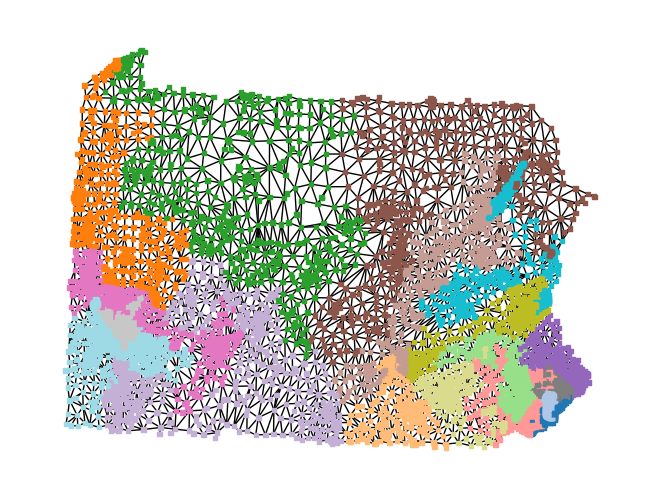

 50%|█████     | 1/2 [00:56<00:56, 56.61s/it]

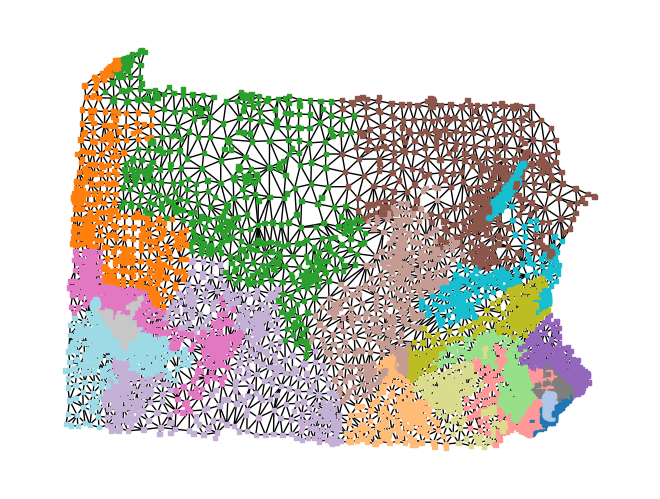

100%|██████████| 2/2 [01:51<00:00, 55.71s/it]


In [21]:
#recom

anim_recom_chain=MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint, #changed from 0.01
        compactness_bound,
        # inclusion_demo
    ],    
    accept= county_VRA_accept, # minimize_county_split_accept, 
    initial_state=initial_partition,
    total_steps=2
)

i = 0

for part in anim_recom_chain.with_progress_bar():
    plt.figure()
    nx.draw(xgraph, 
            pos = {node:(xgraph.nodes[node]["C_X"],xgraph.nodes[node]["C_Y"]) for node in xgraph.nodes()},
            node_color = [dict(part.assignment)[x] for x in xgraph.nodes()] ,
            node_size = ns, 
            node_shape ='s',
            cmap = 'tab20')
    plt.savefig(f"/work/Figures/recom_{i}.png")
    plt.show()
    
    i = i + 1

In [22]:
# boundary
anim_boundary_chain=MarkovChain(
    proposal=propose_random_flip, 
    constraints=[
        pop_constraint, #changed from 0.01
        compactness_bound,
        single_flip_contiguous
        # inclusion_demo
    ],    
    accept=county_VRA_accept, 
    initial_state=initial_partition,
    total_steps= 10
)

i = 0

for part in anim_boundary_chain.with_progress_bar():
    plt.figure()
    nx.draw(xgraph, 
            pos = {node:(xgraph.nodes[node]["C_X"],xgraph.nodes[node]["C_Y"]) for node in xgraph.nodes()},
            node_color = [dict(part.assignment)[x] for x in xgraph.nodes()] ,
            node_size = ns, 
            node_shape ='s',
            cmap = 'tab20')
    #plt.savefig(f"./Figures/bound_{i}.png")
    plt.show()

ValueError: The given initial_state is not valid according is_valid. The failed constraints were: single_flip_contiguous

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=01722cce-db8d-4a90-9749-af129fe2802b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>